In [2]:
import pandas as pd
from src.processing import process_features,process_target, impute_na
from src.evaluation import evaluate, evaluate_forecaster

# Inport SVR model
from sklearn.svm import SVR
import darts
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
x_train_raw = pd.read_csv("data/x_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
y_train_raw = pd.read_csv("data/y_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
x_test_raw = pd.read_csv("data/x_test.csv", index_col= 'DELIVERY_START', parse_dates=True)

x_train, x_train_indices = impute_na(x_train_raw)
x_test, x_test_indices = impute_na(x_test_raw)
y_train, y_train_indices = impute_na(y_train_raw)
proc_x_train, proc_x_test = process_features(x_train,x_test,remove_trend=False, lag_features=False)
proc_y_train = process_target(y_train, binarize=False)

COLUMN :  load_forecast
COLUMN :  coal_power_available
Could not decompose coal_power_available into trend/seasonality, doing simple interpolation
COLUMN :  gas_power_available


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/src/processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
COLUMN :  solar_power_forecasts_average
COLUMN :  wind_power_forecasts_std
COLUMN :  solar_power_forecasts_std
COLUMN :  predicted_spot_price
Could not decompose predicted_spot_price into trend/seasonality, doing simple interpolation
COLUMN :  original


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/src/processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


COLUMN :  load_forecast
COLUMN :  coal_power_available
COLUMN :  gas_power_available
COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
COLUMN :  solar_power_forecasts_average
COLUMN :  wind_power_forecasts_std
COLUMN :  solar_power_forecasts_std
COLUMN :  predicted_spot_price
Could not decompose predicted_spot_price into trend/seasonality, doing simple interpolation
COLUMN :  original
COLUMN :  spot_id_delta


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/src/processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


COLUMN :  original


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 6521, number of used features: 12
[LightGBM] [Info] Start training from score -0.054306
[   0    1    2 ... 6518 6519 6520]
(6521,)
0.9220914791416653
[   0    1    2 ... 4345 4346 4347]
(4348,)
0.43926991605976196
                           spot_id_delta
DELIVERY_START                          
2022-09-29 18:00:00+00:00     116.657892
2022-09-29 19:00:00+00:00      -3.692926
2022-09-29 20:00:00+00:00      -8.232697
2022-09-29 21:00:00+00:00     -50.305175
2022-09-29 22:00:00+00:00     -58.371833
...                                  ...
2023-03-29 17:00:00+00:00       6.029303
2023-03-29 18:00:00+00:00      13.576177
2023-03-29 19:00:00+00:00      17.478945
2023-03-29 20:00:00+00:00      17.559407
2023-03-29 21:00:00+00:00      16.50325

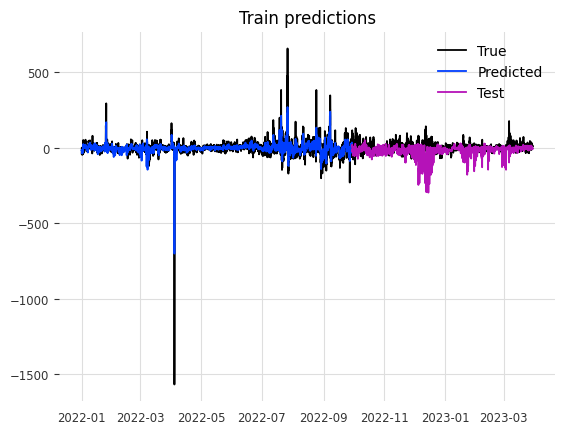

In [12]:
# Split data
N_train = int(len(proc_x_train)*0.6)
x_train_eval, x_test_eval = process_features(x_train[:N_train], x_train[N_train:], remove_trend=False, lag_features=False)
y_train_eval, y_test_eval = y_train[:N_train], y_train[N_train:]
y_train_eval = process_target(y_train_eval, binarize=False)

lgb_train = lgb.Dataset(x_train_eval, label=y_train_eval)
lgb_eval = lgb.Dataset(x_test_eval, label=y_test_eval)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
}

gbm = lgb.train(
    params, lgb_train, valid_sets=lgb_eval
)

# Evaluate model
# print(evaluate(model, x_test_eval, y_test_eval, x_train_indices[0][x_train_indices[0]>=N_train]-N_train))
test_pred = gbm.predict(x_test_eval, num_iteration=gbm.best_iteration)
train_pred = gbm.predict(x_train_eval, num_iteration=gbm.best_iteration)

from src.metrics import weighted_accuracy
indices =  x_train_indices[0][x_train_indices[0]>=N_train]-N_train
print(evaluate(gbm, x_train_eval, y_train_eval, x_train_indices[0][x_train_indices[0]<N_train]))
print(evaluate(gbm, x_test_eval, y_test_eval, indices))
print(y_test_eval)
print(test_pred)

# Visualize predictions
import matplotlib.pyplot as plt

# Plot predictions
plt.plot(y_train.index, y_train, label='True')
plt.plot(x_train_eval.index, train_pred, label='Predicted')
plt.plot(x_test_eval.index, test_pred, label='Test')
plt.title('Train predictions')
plt.legend()
plt.show()